In [1]:
# importing library
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# reading dataset
df = pd.read_csv(r'C:\Users\akank\Dropbox\My PC (LAPTOP-NQ9H8NTJ)\Documents\Sem 8\Project\datasets\brown\brown.csv')

df.head()

,filename,para_id,sent_id,raw_text,tokenized_text,tokenized_pos,label
0,cd05,0,0,"Furthermore/rb ,/, as/cs an/at encouragement/n...","Furthermore , as an encouragement to revisioni...","rb , cs at nn in nn nn , pps rb bez jj to vb c...",religion
1,cd05,0,1,The/at Unitarian/jj clergy/nns were/bed an/at ...,The Unitarian clergy were an exclusive club of...,at jj nns bed at jj nn in vbn nns -- cs at nn ...,religion
2,cd05,0,2,"Ezra/np Stiles/np Gannett/np ,/, an/at honorab...","Ezra Stiles Gannett , an honorable representat...","np np np , at jj nn in at nn , vbd ppl rb in a...",religion
3,cd05,0,3,"Even/rb so/rb ,/, Gannett/np judiciously/rb ar...","Even so , Gannett judiciously argued , the Ass...","rb rb , np rb vbd , at nn-tl md rb vb cs np ``...",religion
4,cd05,0,4,We/ppss today/nr are/ber not/* entitled/vbn to...,We today are not entitled to excoriate honest ...,ppss nr ber * vbn to vb jj nns wps vbd np to b...,religion


# 1. Data Preparation

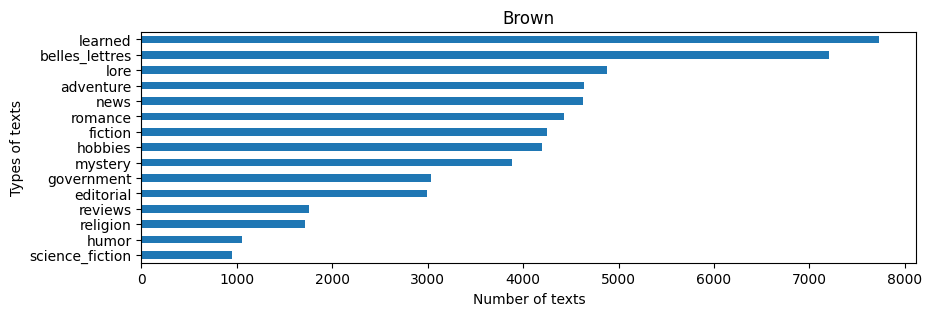

In [3]:
plt.figure(figsize=(10, 3))
df.groupby([df['label']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Brown')
plt.xlabel('Number of texts')
plt.ylabel('Types of texts')
plt.show()

In [4]:
# dropping labels other than defined Fiction and Non-Fiction labels

index = df[(df.label == 'religion') | (df.label == 'lore') | (df.label == 'editorial') | 
(df.label == 'humor') | (df.label == 'belles_lettres')].index

df.drop(index, inplace = True)

In [5]:
# changing labels to fiction_genre and non_fiction_genre

df["label"] = np.where(df["label"] == ('fiction' or 'mystery' or 'romance' or 'adventure' or 'science_fiction'), 
                                        "fiction_genre", "non_fiction_genre")

In [6]:
# dropping paragraphs with sentences less than 5 or 6 (to deal with data imbalance)

sent_count = df.groupby(['filename', 'para_id'], as_index =  False).size()

for i in range(len(sent_count)):
    size = sent_count['size'].iloc[i]
    if((size<5) or (size>6)):
        doc = sent_count['filename'].iloc[i]
        para = sent_count['para_id'].iloc[i]
        index = df[(df['filename'] == doc) & (df['para_id'] == para)].index
        df.drop(index, inplace = True)

In [7]:
# storing labels of each paragraph
df_label = {k: f.groupby('para_id')['label'].apply(list).to_dict()
     for k, f in df.groupby('filename')}

class_label = []
for file_id, filename in df_label.items():
    for para_id, label in filename.items():
            class_label.append(label[0])

pd.DataFrame(class_label, columns= ['label']).to_csv("labels.csv")

# 2. Data Pre-Processing

In [8]:
# removing punctuation
import string

def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

df['tokenized_text_wo_punct'] =  df['tokenized_text'].apply(lambda x: remove_punctuation(x))

In [9]:
# POS Tagging, Dependency and Constituency Parsing is done before Feature Extraction in next step

# 3. Feature Extraction

In [10]:
# from feature_calculation.feature import Features

# # calling Features class from feature.py
# features = Features()

# # creating sentence list for each paragraph
# df_dict = {k: f.groupby('para_id')['tokenized_text_wo_punct'].apply(list).to_dict()
#      for k, f in df.groupby('filename')}

# # getting all features for each paragraph
# feature_list = []
# for file_id, filename in df_dict.items():
#     for para_id, sent_list in filename.items():
#             feature_list.append(features.get_all_features(sent_list))

# # saving the features in a new dataframe
# features = pd.DataFrame(feature_list)
# features.to_csv("extracted_features.csv")

# 4. Supervised Learning

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### 4.1 Baseline Model

In [12]:
# X1 = ...
# y1 = pd.read_csv(r"C:\Users\akank\Dropbox\My PC (LAPTOP-NQ9H8NTJ)\Documents\Sem 8\Project\code\labels.csv")

# X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# baseline = LogisticRegression(penalty = "l1", solver = "saga", max_iter = 1000)
# baseline.fit(X1_train, y1_train.label)
# y1_pred = baseline.predict(X1_test)
# accuracy1_score = baseline.score(X1_test, y1_test.label)

# print('\nTesting Accuracy:\n', accuracy1_score)
# print('\nClassification Report:\n', classification_report(y1_test.label, y1_pred))

### 4.2. On Extracted Features

In [13]:
# calling the dataframe which will be used for training
data = pd.read_csv(r"C:\Users\akank\Dropbox\My PC (LAPTOP-NQ9H8NTJ)\Documents\Sem 8\Project\code\extracted_features_wo_sen.csv")
y = pd.read_csv(r"C:\Users\akank\Dropbox\My PC (LAPTOP-NQ9H8NTJ)\Documents\Sem 8\Project\code\labels.csv")
data = data.fillna(0)

# scaling data
scaler = StandardScaler()
X = scaler.fit_transform(data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# defining classifier
clf = LogisticRegression(penalty = 'l1', solver= 'saga', max_iter = 2500)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=10, 
    scoring= "accuracy",
    n_jobs=2,
)
rfecv.fit(X_train, y_train.label)

c:\Users\akank\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\akank\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\akank\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\akank\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\akank\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

RFECV(cv=10,
      estimator=LogisticRegression(max_iter=2500, penalty='l1', solver='saga'),
      n_jobs=2, scoring='accuracy')

In [20]:
clf.fit(X_train, y_train.label)
y_pred1 = clf.predict(X_test)
test_accuracy_score1 = rfecv.score(X_test, y_test.label)
train_accuracy_score1 = rfecv.score(X_train, y_train.label)
coefficients = clf.coef_

print('\nTraining Accuracy:\n', train_accuracy_score1)
print('\nTesting Accuracy:\n', test_accuracy_score1)
print('\nClassification Report:\n', classification_report(y_test.label, y_pred1))
print('\nCoefficients:\n', coefficients)


Training Accuracy:
 0.8890728476821192

Testing Accuracy:
 0.9105960264900662

Classification Report:
                    precision    recall  f1-score   support

    fiction_genre       0.32      0.26      0.29        27
non_fiction_genre       0.93      0.95      0.94       275

         accuracy                           0.88       302
        macro avg       0.62      0.60      0.61       302
     weighted avg       0.87      0.88      0.88       302


Coefficients:
 [[ 1.27359011e+00  4.88436442e-01 -6.87324529e-01 -4.69233473e-01
  -1.00605155e-01 -1.49340762e-01 -1.38478504e-01  2.56587447e-01
   0.00000000e+00  4.29437832e-02  0.00000000e+00 -1.88576615e-01
   0.00000000e+00  1.11596686e-01 -6.97167232e-03 -2.79035295e-03
   2.78143615e-01 -2.51251391e-02  5.48629419e-01 -2.67298191e-01
   5.26198412e-01  0.00000000e+00  0.00000000e+00 -2.81346385e-01
  -1.79416189e-01  0.00000000e+00  4.96769514e-01  0.00000000e+00
   2.24669297e-01  0.00000000e+00  7.30120473e-01 -5.94794591

c:\Users\akank\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# 5. Results

In [15]:
y_pred = rfecv.predict(X_test)
test_accuracy_score = rfecv.score(X_test, y_test.label)
train_accuracy_score = rfecv.score(X_train, y_train.label)

print('\nTraining Accuracy:\n', train_accuracy_score)
print('\nTesting Accuracy:\n', test_accuracy_score)
print('\nClassification Report:\n', classification_report(y_test.label, y_pred))


Training Accuracy:
 0.8890728476821192

Testing Accuracy:
 0.9105960264900662

Classification Report:
                    precision    recall  f1-score   support

    fiction_genre       0.00      0.00      0.00        27
non_fiction_genre       0.91      1.00      0.95       275

         accuracy                           0.91       302
        macro avg       0.46      0.50      0.48       302
     weighted avg       0.83      0.91      0.87       302



c:\Users\akank\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\akank\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\akank\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [17]:
ranking = rfecv.ranking_
print(f"Ranking of features (Selected features are given rank 1): {rfecv.ranking_}")
print(data.columns)

optimal_features = []
for i in range(len(data.columns)):
    if((rfecv.ranking_[i])==1):
        optimal_features.append(data.columns[i])

print(f"Optimal number of features: {rfecv.n_features_}")
print('\nOptimal feature used for classification:\n', optimal_features)

Ranking of features (Selected features are given rank 1): [  9  77  34  58 210 110 102  55 256 203 265 149 255 177 252 278  93 285
  40  48   1 263 291  70  72 273  21 271 118 267   6  54  95 131  13 277
 196 290   7 169  42  35  19 312 269 120 326 257  44 300  79 347 247  91
  22 260 360   8 279 202  68  17 283  78 266  16 272 104 324  52  12 222
  18 224 191 301  85 154 343 111 198  10 121 240 330  32 323 201 194 186
   5   3  24 148 361  25 364 365 245 294 358 238 227 236 170  31  66  30
 176 119  45 173 193 127 228  26  11   2 195 315 165  39 188 200 234  38
  97 230  69 133 187 166 185 319 123 157  98  43 223 218  94  65   4  41
 167 286  99 182 192 164 246  96 126 220  47  46 221 346  87  51 136 311
  15 172 354  23  53 209 325  20 114  64 151 162 105 206 184 135  75 242
  27  37  36 125 156 229 134  67  62 348 249 106 215 107 233 276 244 163
 197 237  14 331 216 130  28  33 337 190 150 152 303 270 113 153 261 171
  49 115  86  50  76 353 204 310 140 211 292 251 122 181 128 235 2

In [47]:
# pd.DataFrame((ranking), columns= ['Rank']).to_csv("ranks.csv")
# rank = pd.read_csv(r"C:\Users\akank\Dropbox\My PC (LAPTOP-NQ9H8NTJ)\Documents\Sem 8\Project\code\ranks.csv")
# rank['Features'] = data.columns
# coefficients = coefficients.flatten()
# rank['Coefficient'] = coefficients
# rank.drop(rank.columns[[0, 1]], axis=1, inplace=True)
# rank = rank.sort_values("Rank")
# rank.to_csv("rank.csv", index = False)
# rank = pd.read_csv(r"C:\Users\akank\Dropbox\My PC (LAPTOP-NQ9H8NTJ)\Documents\Sem 8\Project\code\rank.csv")

In [18]:
# storing values of the features for each class
count_fiction = {'adjadv': 0, 'advpron': 0, 'nounverb': 0, 'maasTTR': 0, 'confunc': 0, 
                 "('VERB', 'PRON', 'before')": 0, "('VERB', 'PROPN', 'after')": 0, "('VERB', 'ADV', 'before')":0, "('VERB', 'ADP', 'before')": 0}
count_nonfiction = {'adjadv': 0, 'advpron': 0, 'nounverb': 0, 'maasTTR': 0, 'confunc': 0, 
                    "('VERB', 'PRON', 'before')": 0, "('VERB', 'PROPN', 'after')": 0, "('VERB', 'ADV', 'before')":0, "('VERB', 'ADP', 'before')": 0}
                    # 'noun': 0,'verb': 0, 'pronoun': 0, 'adjective': 0, 'adverb': 0

for i in range(len(data.columns)):
    if(y.label[i] == 'fiction_genre'):
        count_fiction['adjadv'] += data.loc[i].at['adjective/verb']
        count_fiction['advpron'] += data.loc[i].at['adverb/pronoun']
        count_fiction['nounverb'] += data.loc[i].at['noun/verb']
        count_fiction['maasTTR'] += data.loc[i].at['Maas TTR']
        count_fiction['confunc'] += data.loc[i].at['content/function']
        count_fiction["('VERB', 'PRON', 'before')"] += data.loc[i].at["('VERB', 'PRON', 'before')"]
        count_fiction["('VERB', 'PROPN', 'after')"] += data.loc[i].at["('VERB', 'PROPN', 'after')"]
        count_fiction["('VERB', 'ADV', 'before')"] += data.loc[i].at["('VERB', 'ADV', 'before')"]
        count_fiction["('VERB', 'ADP', 'before')"] += data.loc[i].at["('VERB', 'ADP', 'before')"]
        # count_fiction['noun'] += data.loc[i].at['noun']
        # count_fiction['verb'] += data.loc[i].at['verb']
        # count_fiction['pronoun'] += data.loc[i].at['pronoun']
        # count_fiction['adjective'] += data.loc[i].at['adjective']
        # count_fiction['adverb'] += data.loc[i].at['adverb']

    elif(y.label[i] =='non_fiction_genre'): 
        count_nonfiction['adjadv'] += data.loc[i].at['adjective/verb']
        count_nonfiction['advpron'] += data.loc[i].at['adverb/pronoun']
        count_nonfiction['nounverb'] += data.loc[i].at['noun/verb']
        count_nonfiction['maasTTR'] += data.loc[i].at['Maas TTR']
        count_nonfiction['confunc'] += data.loc[i].at['content/function']
        count_nonfiction["('VERB', 'PRON', 'before')"] += data.loc[i].at["('VERB', 'PRON', 'before')"]
        count_nonfiction["('VERB', 'PROPN', 'after')"] += data.loc[i].at["('VERB', 'PROPN', 'after')"]
        count_nonfiction["('VERB', 'ADV', 'before')"] += data.loc[i].at["('VERB', 'ADV', 'before')"]
        count_nonfiction["('VERB', 'ADP', 'before')"] += data.loc[i].at["('VERB', 'ADP', 'before')"]
        # count_nonfiction['noun'] += data.loc[i].at['noun']
        # count_nonfiction['verb'] += data.loc[i].at['verb']
        # count_nonfiction['pronoun'] += data.loc[i].at['pronoun']
        # count_nonfiction['adjective'] += data.loc[i].at['adjective']
        # count_nonfiction['adverb'] += data.loc[i].at['adverb']

In [48]:
print('\nCount of Features for Fiction Genre:\n', count_fiction)
print('\nCount of Features for Non-Fiction Genre:\n', count_nonfiction)


Count of Features for Fiction Genre:
 {'adjadv': 0, 'advpron': 0, 'nounverb': 0, 'maasTTR': 0, 'confunc': 0, "('VERB', 'PRON', 'before')": 0, "('VERB', 'PROPN', 'after')": 0, "('VERB', 'ADV', 'before')": 0, "('VERB', 'ADP', 'before')": 0}

Count of Features for Non-Fiction Genre:
 {'adjadv': 374.53012734169886, 'advpron': 339.8313354129531, 'nounverb': 950.8214510154447, 'maasTTR': 454.4035643985181, 'confunc': 186.0829658412804, "('VERB', 'PRON', 'before')": 240.0, "('VERB', 'PROPN', 'after')": 268.0, "('VERB', 'ADV', 'before')": 249.0, "('VERB', 'ADP', 'before')": 156.0}


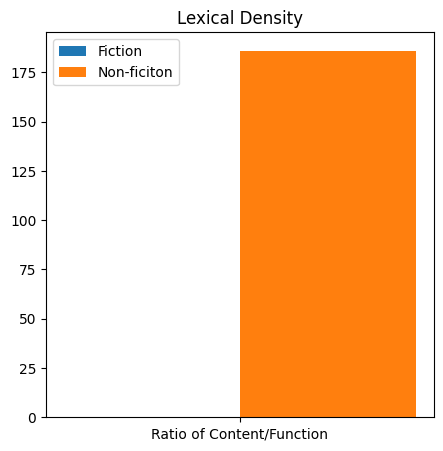

In [49]:
# Plot 1: Content to Function Ratio
N = 1
ind = np.arange(N)
width = 0.3

blue_bar = count_fiction['confunc']
orange_bar =  count_nonfiction['confunc']

plt.figure(figsize=(5,5))
plt.bar(ind, blue_bar , width, label='Fiction')
plt.bar(ind + width, orange_bar, width, label='Non-ficiton')
plt.title('Lexical Density')
plt.xticks(ind + width / 2, ('Ratio of Content/Function', ))
plt.legend(loc='best')
plt.show()

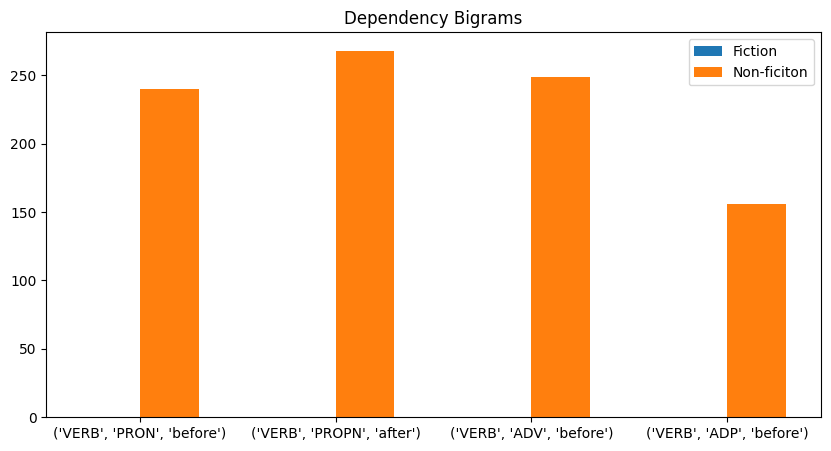

In [50]:
# Plot 2:
N = 4
ind = np.arange(N)
width = 0.3 

blue_bar = (count_fiction["('VERB', 'PRON', 'before')"],
            count_fiction["('VERB', 'PROPN', 'after')"], 
            count_fiction["('VERB', 'ADV', 'before')"], 
            count_fiction["('VERB', 'ADP', 'before')"])
orange_bar = (count_nonfiction["('VERB', 'PRON', 'before')"],
            count_nonfiction["('VERB', 'PROPN', 'after')"], 
            count_nonfiction["('VERB', 'ADV', 'before')"], 
            count_nonfiction["('VERB', 'ADP', 'before')"])
 
plt.figure(figsize=(10,5))
plt.bar(ind, blue_bar , width, label='Fiction')
plt.bar(ind + width, orange_bar, width, label='Non-ficiton')
plt.title('Dependency Bigrams')
plt.xticks(ind + width / 2, (('VERB', 'PRON', 'before'), ('VERB', 'PROPN', 'after'), ('VERB', 'ADV', 'before'), ('VERB', 'ADP', 'before')))
plt.legend(loc='best')
plt.show()

In [ ]:
# Plot 3: POS Ratios
# N = 5
# ind = np.arange(N)
# width = 0.3       

# blue_bar = (count_fiction['noun'],
#             count_fiction['verb'],
#             count_fiction['pronoun'],
#             count_fiction['adjective'],
#             count_fiction['adverb'])

# orange_bar = (count_nonfiction['noun'],
#             count_nonfiction['verb'],
#             count_nonfiction['pronoun'],
#             count_nonfiction['adjective'],
#             count_nonfiction['adverb'])

# plt.figure(figsize=(10,5))
# plt.bar(ind, blue_bar , width, label='Fiction')
# plt.bar(ind + width, orange_bar, width, label='Non-ficiton')
# plt.title('Dependency Bigrams')
# # xticks()
# plt.xticks(ind + width / 2, ('noun', 'verb', 'pronoun', 'adjective', 'adverb'))
# plt.legend(loc='best')
# plt.show()